# Vision Transformer (ViT)

In this assignment we're going to work with Vision Transformer. 

We will start to build our own vit model and train it on an image classification task.

The purpose of this homework is for you to get familar with ViT and get prepared for the final project. 

In [17]:
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


## VIT Implementation

The vision transformer can be seperated into three parts, we will implement each part and combine them in the end.

For the implementation, feel free to experiment different kinds of setup, as long as you use attention as the main computation unit and the ViT can be train to perform the image classification task present later.

You can read about the ViT implement from other libary: 

https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/vision_transformer.py, 

https://github.com/pytorch/vision/blob/main/torchvision/models/vision_transformer.py

## PatchEmbedding
PatchEmbedding is responsible for dividing the input image into non-overlapping patches and projecting them into a specified embedding dimension. 

It uses a 2D convolution layer with a kernel size and stride equal to the patch size. 

The output is a sequence of linear embeddings for each patch.

In [19]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, num_hiddens):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.conv = nn.Conv2d(in_channels, num_hiddens, kernel_size=patch_size, stride=patch_size)

    def forward(self, X):
        # input shape:  (batch_size, in_channels, img_size, img_size)
        # return shape: (batch_size, num_patches, num_hiddens)
        return self.conv(X).flatten(2).transpose(1, 2)

img_size, patch_size, in_channels, num_hiddens, batch_size = 96, 16, 3, 512, 1
patch_emb = PatchEmbedding(img_size, patch_size, in_channels, num_hiddens)
X = torch.zeros(batch_size, in_channels, img_size, img_size)
print(patch_emb.num_patches)
patch_emb(X).shape

36


torch.Size([1, 36, 512])

## Multi-Head Self-Attention

This class implements the multi-head self-attention mechanism, which is a key component of the transformer architecture. 

It consists of multiple attention heads that independently compute scaled dot-product attention on the input embeddings. 
This allows the model to capture different aspects of the input at different positions. 

The attention outputs are concatenated and linearly transformed back to the original embedding size.

In [20]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, num_hiddens, num_heads, dropout=0.1):
        super().__init__()
        assert num_hiddens % num_heads == 0
        self.num_heads = num_heads
        self.dropout = dropout
        qkv_bias = False
        self.W_q = nn.LazyLinear(num_hiddens, bias=qkv_bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=qkv_bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=qkv_bias)
        self.W_h = nn.Linear(num_hiddens, num_hiddens)

    def dot_product_attention(self, Q, K, V):
        # input shape:  (batch_size, num_heads, num_patches, num_hiddens/num_heads)
        # output shape: (batch_size, num_heads, num_patches, num_hiddens/num_heads)
        d = Q.shape[-1]
        scores = torch.matmul(Q, K.transpose(-2,-1)) / np.sqrt(d)  # (batch_size, num_heads, num_patches, num_patches)
        A = nn.Softmax(dim=-1)(scores)
        H = torch.matmul(nn.Dropout(self.dropout)(A), V)  # (batch_size, num_heads, num_patches, num_hiddens/num_heads)
        return H
    
    def split_heads(self, X):
        # input:  (batch_size, num_patches, num_hiddens)
        # output: (batch_size, num_heads, num_patches, num_hiddens/num_heads)
        return X.reshape(X.shape[0], X.shape[1], self.num_heads, -1).transpose(1, 2)
    
    def concat_heads(self, X):
        # input:  (batch_size, num_heads, num_patches, num_hiddens/num_heads)
        # output: (batch_size, num_patches, num_hiddens)
        X = X.transpose(1,2)
        return X.reshape(X.shape[0], X.shape[1], -1)

    def forward(self, X):
        # input shape:  (batch_size, num_patches, in_hiddens)
        # return shape: (batch_size,)
        Q = self.split_heads(self.W_q(X))  # (batch_size, num_heads, num_patches, num_hiddens/num_heads)
        K = self.split_heads(self.W_k(X))
        V = self.split_heads(self.W_v(X))
        H = self.dot_product_attention(Q, K, V)  # (batch_size, num_heads, num_patches, num_hiddens/num_heads)
        H = self.W_h(self.concat_heads(H))  # (batch_size, num_patches, num_hiddens)
        return H

num_hiddens, num_heads = 512, 8
attention = MultiHeadSelfAttention(num_hiddens, num_heads)
X = torch.zeros(1, 36, 256)  # (batch_size, num_patches, in_hiddens)
attention(X).shape  # (batch_size, num_patches, num_hiddens)

torch.Size([1, 36, 512])

## TransformerBlock
This class represents a single transformer layer. 
It includes a multi-head self-attention sublayer followed by a position-wise feed-forward network (MLP). 

Each sublayer is surrounded by residual connections.

You may also want to use layer normalization or other type of normalization.

In [21]:
class TransformerBlock(nn.Module):
    def __init__(self, num_hiddens, num_heads, mlp_hiddens, dropout):
        super().__init__()
        self.norm1 = nn.LayerNorm(num_hiddens)
        self.attention = MultiHeadSelfAttention(num_hiddens, num_heads, dropout)
        self.norm2 = nn.LayerNorm(num_hiddens)
        self.mlp = nn.Sequential(
            nn.Linear(num_hiddens, mlp_hiddens),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hiddens, num_hiddens),
            nn.Dropout(dropout)
        )
    
    def forward(self, X):
        X = X + self.attention(self.norm1(X))
        X = X + self.mlp(self.norm2(X))
        return X

num_hiddens, num_heads, mlp_hiddens, dropout = 512, 8, 2048, 0.1
ViTblock = TransformerBlock(num_hiddens, num_heads, mlp_hiddens, dropout)
X = torch.zeros(1, 36, num_hiddens)
ViTblock(X).shape  # Transformer block does not change size

torch.Size([1, 36, 512])

In [37]:
# 11 x 2048 x 5 x 8
# 440 x 2048
# Linear: 440 x 512

# Block: 440 x 512
# Block: 440 x 512

# Linear: 440 x 2048
# Linear: 2048 x 40 = 2048 x 5 x 8

num_hiddens = 512

ViTblock = TransformerBlock(num_hiddens, 8, 2048, dropout)

x = torch.zeros(1, 440, num_hiddens)

ViTblock(x).shape

torch.Size([1, 440, 512])

In [38]:

from torchinfo import summary

summary(ViTblock, input_size=(440, num_hiddens), batch_dim=0)

Layer (type:depth-idx)                   Output Shape              Param #
TransformerBlock                         [1, 440, 512]             --
├─LayerNorm: 1-1                         [1, 440, 512]             1,024
├─MultiHeadSelfAttention: 1-2            [1, 440, 512]             --
│    └─Linear: 2-1                       [1, 440, 512]             262,144
│    └─Linear: 2-2                       [1, 440, 512]             262,144
│    └─Linear: 2-3                       [1, 440, 512]             262,144
│    └─Linear: 2-4                       [1, 440, 512]             262,656
├─LayerNorm: 1-3                         [1, 440, 512]             1,024
├─Sequential: 1-4                        [1, 440, 512]             --
│    └─Linear: 2-5                       [1, 440, 2048]            1,050,624
│    └─GELU: 2-6                         [1, 440, 2048]            --
│    └─Dropout: 2-7                      [1, 440, 2048]            --
│    └─Linear: 2-8                       [1, 440, 51

## VisionTransformer
This is the main class that assembles the entire Vision Transformer architecture. 

It starts with the PatchEmbedding layer to create patch embeddings from the input image. 

A special class token is added to the sequence, and positional embeddings are added to both the patch and class tokens. 

The sequence of patch embeddings is then passed through multiple TransformerBlock layers. 

The final output is the logits for all classes

In [6]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, num_hiddens, num_heads, mlp_dim, num_layers, num_classes, dropout=0.1):
        super().__init__()
        self.patch_embeding = PatchEmbedding(img_size, patch_size, in_channels, num_hiddens)
        self.class_token = nn.Parameter(torch.zeros(1, 1, num_hiddens))
        self.pos_embedding = nn.Parameter(0.02 * torch.randn(1, self.patch_embeding.num_patches + 1, num_hiddens))
        self.dropout = nn.Dropout(dropout)
        self.blocks = nn.Sequential()
        for i in range(num_layers):
            self.blocks.add_module(f"{i}", TransformerBlock(num_hiddens, num_heads, mlp_dim, dropout))
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(num_hiddens),
            nn.Linear(num_hiddens, num_classes)
        )

    def forward(self, X):
        X = self.patch_embeding(X)
        X = torch.cat((self.class_token.expand(X.shape[0], -1, -1), X), dim=1)
        X = self.dropout(X + self.pos_embedding)
        for block in self.blocks:
            X = block(X)
        X = self.mlp_head(X[:, 0])
        return X

img_size, patch_size, in_channels, num_hiddens, num_heads, mlp_dim, num_layers, num_classes = 96, 16, 3, 512, 8, 2048, 2, 100
ViT = VisionTransformer(img_size, patch_size, in_channels, num_hiddens, num_heads, mlp_dim, num_layers, num_classes)
X = torch.zeros(1, in_channels, img_size, img_size)
ViT(X).shape

torch.Size([1, 100])

## Dataset

Load the CIFAR-100 dataset

In [7]:
patch_size = 8
image_size = 96

num_classes = 100
in_channels = 3  # RGB

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

100%|██████████| 169001437/169001437 [00:27<00:00, 6149603.31it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


## Training

We will train the vit to do the image classification with CIFAR100.

In [8]:
batch_size = 512

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

In [9]:
class WarmupCosineSchedOptim():
    def __init__(self, optimizer, warmup_steps, total_steps, lr_max, lr_min=0.0):
        self.optimizer = optimizer
        self.steps = 0
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.lr_max = lr_max
        self.lr_min = lr_min
    
    def zero_grad(self):
        self.optimizer.zero_grad()

    def step(self):
        self.update_lr()
        self.optimizer.step()

    def update_lr(self):
        self.steps += 1
        if self.steps <= self.warmup_steps:
            lr = (self.steps / self.warmup_steps) * self.lr_max
        else:
            ratio = min(1.0, (self.steps - self.warmup_steps) / (self.total_steps - self.warmup_steps))
            lr = self.lr_min + 0.5 * (self.lr_max - self.lr_min) * (1 + np.cos(np.pi * ratio))
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

In [10]:
def train_and_val(num_epochs, model, trainloader, testloader, optimizer, criterion, device, model_name="model"):
    best_val_acc = 0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        val_running_loss = 0.0
        correct, total = 0, 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss.backward()
            optimizer.step()
        train_acc = correct / total
        train_accs.append(train_acc)

        # Validate the model
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss = criterion(outputs, labels)
                val_running_loss += val_loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc = correct / total
        val_accs.append(val_acc)

        train_losses.append(running_loss/len(trainloader))
        val_losses.append(val_running_loss/len(trainloader))

        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"\tEpoch: {epoch+1:3d}/{num_epochs:3d}, Loss: {running_loss/len(trainloader):.3e}, Train Accuracy: {train_acc*100:.2f}%, Val Accuracy: {val_acc*100:.2f}%")

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_name + ".pth")

    return best_val_acc, train_losses, train_accs, val_losses, val_accs

In [11]:
def plot_loss_and_acc(train_losses, train_accs, val_losses, val_accs, model_name="model"):
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    axs[0].plot(train_losses)
    axs[0].plot(val_losses)
    axs[0].set_yscale('log')
    axs[0].grid()
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend(["Train loss", "Val loss"])
    # axs[0].set_ylim([1e-3, 1e1])

    axs[1].plot(train_accs)
    axs[1].plot(val_accs)
    axs[1].grid()
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(["Train acc", "Val acc"])
    axs[1].set_ylim([0, 1.0])
    
    fig.savefig(model_name + ".pdf")

### ViT Model

In [12]:
# ViT
num_layers = 6
hidden_dim = 384
mlp_dim = hidden_dim * 4
num_heads = 6

dropout = 0.2

model = VisionTransformer(image_size, patch_size, in_channels, hidden_dim, num_heads, mlp_dim, num_layers, num_classes, dropout).to(device)

In [16]:
summary(model, input_size=(3, image_size, image_size), batch_dim=0)

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 100]                  56,064
├─PatchEmbedding: 1-1                         [1, 144, 384]             --
│    └─Conv2d: 2-1                            [1, 384, 12, 12]          74,112
├─Dropout: 1-2                                [1, 145, 384]             --
├─Sequential: 1-3                             --                        --
│    └─TransformerBlock: 2-2                  [1, 145, 384]             --
│    │    └─LayerNorm: 3-1                    [1, 145, 384]             768
│    │    └─MultiHeadSelfAttention: 3-2       [1, 145, 384]             590,208
│    │    └─LayerNorm: 3-3                    [1, 145, 384]             768
│    │    └─Sequential: 3-4                   [1, 145, 384]             1,181,568
│    └─TransformerBlock: 2-3                  [1, 145, 384]             --
│    │    └─LayerNorm: 3-5                    [1, 145, 384]             7

### Training

with AdamW and weight decay.

In [39]:
num_epochs = 60

lr_max = 1e-3
weight_decay = 0.3

total_steps = num_epochs * len(trainloader)
warmup_steps = int(0.01 * total_steps)

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=weight_decay)
sched_optimizer = WarmupCosineSchedOptim(optimizer, warmup_steps, total_steps, lr_max)

model_name = "model_ViT-Small-v0_lr_" + str(lr_max) + "_decay_" + str(weight_decay) + "_ep_" + str(num_epochs)

In [40]:
best_val_acc, train_losses, train_accs, val_losses, val_accs = \
    train_and_val(num_epochs, model, trainloader, testloader, sched_optimizer, criterion, device, model_name)

  2%|▏         | 1/60 [00:44<44:04, 44.83s/it]

Epoch:   1/ 60, Loss: 4.034e+00, Train Accuracy: 8.16%, Val Accuracy: 13.05%


  8%|▊         | 5/60 [03:43<41:03, 44.79s/it]

Epoch:   5/ 60, Loss: 2.882e+00, Train Accuracy: 27.34%, Val Accuracy: 25.83%


 17%|█▋        | 10/60 [07:27<37:18, 44.77s/it]

Epoch:  10/ 60, Loss: 2.291e+00, Train Accuracy: 39.05%, Val Accuracy: 38.35%


 25%|██▌       | 15/60 [11:11<33:34, 44.76s/it]

Epoch:  15/ 60, Loss: 1.861e+00, Train Accuracy: 48.99%, Val Accuracy: 44.90%


 33%|███▎      | 20/60 [14:55<29:50, 44.77s/it]

Epoch:  20/ 60, Loss: 1.381e+00, Train Accuracy: 60.28%, Val Accuracy: 49.73%


 42%|████▏     | 25/60 [18:39<26:06, 44.76s/it]

Epoch:  25/ 60, Loss: 9.316e-01, Train Accuracy: 71.85%, Val Accuracy: 50.90%


 50%|█████     | 30/60 [22:23<22:22, 44.74s/it]

Epoch:  30/ 60, Loss: 5.483e-01, Train Accuracy: 83.06%, Val Accuracy: 53.38%


 58%|█████▊    | 35/60 [26:06<18:37, 44.69s/it]

Epoch:  35/ 60, Loss: 3.218e-01, Train Accuracy: 90.48%, Val Accuracy: 53.89%


 67%|██████▋   | 40/60 [29:49<14:53, 44.66s/it]

Epoch:  40/ 60, Loss: 1.925e-01, Train Accuracy: 94.49%, Val Accuracy: 54.86%


 75%|███████▌  | 45/60 [33:33<11:10, 44.67s/it]

Epoch:  45/ 60, Loss: 1.236e-01, Train Accuracy: 96.81%, Val Accuracy: 55.70%


 83%|████████▎ | 50/60 [37:16<07:27, 44.74s/it]

Epoch:  50/ 60, Loss: 8.114e-02, Train Accuracy: 98.13%, Val Accuracy: 55.97%


 92%|█████████▏| 55/60 [41:02<03:45, 45.00s/it]

Epoch:  55/ 60, Loss: 6.487e-02, Train Accuracy: 98.56%, Val Accuracy: 56.21%


100%|██████████| 60/60 [44:46<00:00, 44.77s/it]

Epoch:  60/ 60, Loss: 6.030e-02, Train Accuracy: 98.69%, Val Accuracy: 56.82%


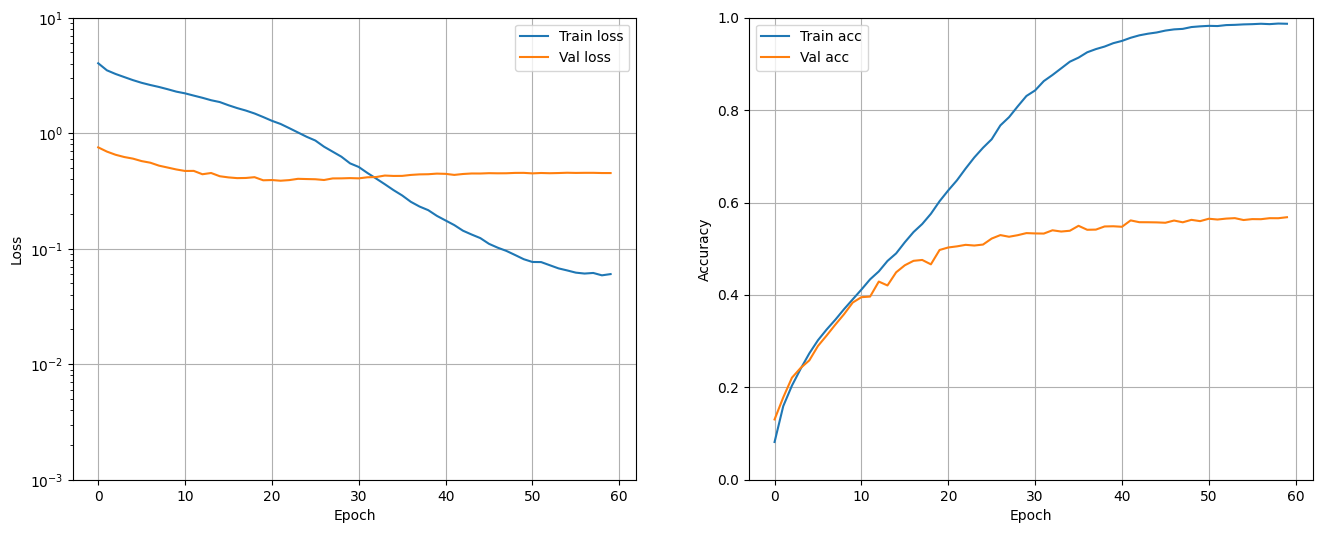

In [41]:
plot_loss_and_acc(train_losses, train_accs, val_losses, val_accs, model_name)

The best validation accuracy is:

In [44]:
print(best_val_acc)

0.5682
